# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Skillfactory---Практический-Machine-Learning" data-toc-modified-id="Skillfactory---Практический-Machine-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Skillfactory - Практический Machine Learning</a></div><div class="lev2 toc-item"><a href="#Обучение-без-учителя,-понижение-размерности,-кластеризация" data-toc-modified-id="Обучение-без-учителя,-понижение-размерности,-кластеризация-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обучение без учителя, понижение размерности, кластеризация</a></div><div class="lev3 toc-item"><a href="#Иерархическая-кластеризация:-Пищевая-ценность-продуктов" data-toc-modified-id="Иерархическая-кластеризация:-Пищевая-ценность-продуктов-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Иерархическая кластеризация: Пищевая ценность продуктов</a></div><div class="lev2 toc-item"><a href="#DBSCAN:-Геоданные" data-toc-modified-id="DBSCAN:-Геоданные-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>DBSCAN: Геоданные</a></div><div class="lev3 toc-item"><a href="#Отток-в-игре:-PCA-+-RFE" data-toc-modified-id="Отток-в-игре:-PCA-+-RFE-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Отток в игре: PCA + RFE</a></div><div class="lev3 toc-item"><a href="#Сжатие-признаков-для-визуализации" data-toc-modified-id="Сжатие-признаков-для-визуализации-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Сжатие признаков для визуализации</a></div><div class="lev3 toc-item"><a href="#RFE-+-Decision-tree" data-toc-modified-id="RFE-+-Decision-tree-123"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>RFE + Decision tree</a></div>

# Skillfactory - Практический Machine Learning
## Обучение без учителя, понижение размерности, кластеризация

<center> Шестаков Андрей </center>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, IntSlider, fixed, FloatSlider

### Иерархическая кластеризация: Пищевая ценность продуктов

Загрузите файл `food.txt`. В нем содержится информация о пищевой ценности разных продуктов

In [ ]:
df = pd.read_csv('data/food.txt', sep=' ')
df.head()

* Подготовте данные к кластеризации 
    * Выделите признаки в матрицу X (numpy array)
    * Отнормируйте признаки

* Произведите иерарническую кластеризацию этого набора данных (метод `linkage`)
* Выберите тип пересчета расстояния между кластерами с помощью кофенетической корреляции

In [ ]:
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage, cophenet

* Изобразите дендрограмму
    * Сначала просто посмотрите на результат метода `dendrogram`
    * Сделаем визуализацию более наглядной:
        * Выделите названия продуктов в numpy array c названием `names`
        * Выполните `dendrogram`  аргументами `orientation='left'`, `labels=names`
        * Теперь мы должны увидеть, что дендрограмма транспонировалась и вместо безымянных индексов мы имеем наименования объектов

* Выделите кластеры по дендрограмме с помощью метода `fcluster`
    * Наличие кластеров, состоящих из одного объекта - нормальное явление, если это можно объяснить

## DBSCAN: Геоданные

In [ ]:
# Опционально, установите установите matplotlib.basemap
# Либо закоментируйте команду ниже
import mpl_toolkits.basemap as bm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

Загрузите геоданные из `geo_data.txt` (lat, lon).

Будем пытаться кластеризовать данные с помощью DBSCAN и меры [haversine](https://en.wikipedia.org/wiki/Haversine_formula)

In [ ]:
df_geo = pd.read_csv('data/geo_data.txt', sep='\t', header=None,
                     names=['lat', 'lon'])/10000

In [ ]:
df_geo.head()

In [16]:
def plot_geo(lat, lon, labels=None):    
    try:
        lllat, lllon = lat.min()-1, lon.max()+1
        urlat, urlon = lat.max()+1, lon.min()-1

        plt.figure(figsize=(10, 10))

        m = bm.Basemap(
            llcrnrlon=lllon,
            llcrnrlat=lllat,
            urcrnrlon=urlon,
            urcrnrlat=urlat, 
            projection='merc',
            resolution='h'
        )

        m.drawcoastlines(linewidth=0.5)
        m.drawmapboundary(fill_color='#47A4C9', zorder=1)
        m.fillcontinents(color='#EBC4D8',lake_color='#47A4C9', zorder=2)

        parallels = np.linspace(lllat, urlat, 10)
        m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
        # draw meridians
        meridians = np.linspace(urlon, lllon, 10)
        m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

        m.scatter(lon, lat, latlon=True, cmap=plt.cm.jet,
              zorder=3, lw=0, c=labels)
    except:
        print('что-то пошло не так')
        plt.scatter(x=lon, y=lat, c=labels, cmap=plt.cm.jet)
        plt.axis('equal')

Для начала нарисуем все точки на карте

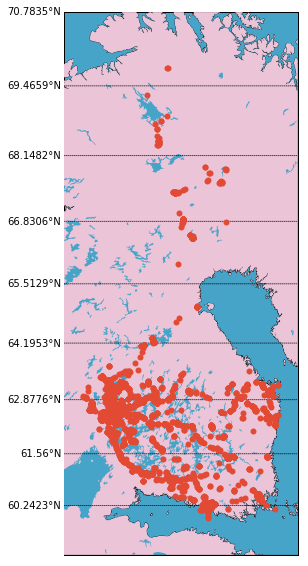

In [18]:
plot_geo(df_geo.loc[:, 'lat'].values, df_geo.loc[:, 'lon'].values)

Это данные с check-in людей в foursquare. В данных могут быть ошибки и просто непопулярные заведения.

Мы будем использовать расстояние haversine - на входе требуются координаты в **радианах**. Выход тоже будет в радианах. Чтобы перейти от градусов в радианты мы можем вспомнить тригонометрию, а можем воспользоваться функцией `np.radians`.

Для кого, чтобы не терять связь с реальностью, будем иметь ввиду, что расстояние в 1 радиан на земном шаре равно примерно 6371.0088 километрам.

Создайте матрицу X с координатами в радианах

In [ ]:
km_in_radian = 6371.0088
X = np.radians(df_geo.values)

Как же определить, какие параметры для DBSCAN выставлять? Наибольшую проблемы представляет параметр eps.

Будем считать, что MinPts нам дан свыше  например для себя мы определили, что кластером будет считаться группа из **минимум** 20 точек - MinPts = 20). Воспользуемся следующим способом оценки:

* Расчитайте расстояние до k=MinPts ближайшего соседа каждой точки (класс `NearestNeighbors` и метод `kneighbors`)
* Отсортируйте полученный массив и выведите его на график
* По графику будет примерно понятно, сколько точек уйдет в шум, а сколько попадет в полноценный кластер при всевозможных `eps`
* Выберите eps, при котором график начинает "уходить вверх" (примерно 0.02-0.06, если все было сделано верно)

In [ ]:
nn = NearestNeighbors()


Определим eps мы можем начать кластеризацию

* Создайте экземпляр класса DBSCAN, кластеризуйте данные
* Выведите полученные метки кластеров и их частоты
* Интерпретировать кластеры может оказаться затруднительно, но можно избавить от выборов и посмотреть на результат
    * Изобразите координаты точек, не попавших в кластер выбросов (метка -1) 

### Отток в игре: PCA + RFE

В этих данных предлагается построить модель оттока игрока из игрового проекта

Целевой мерой является `log_loss` - чем меньше значение, тем лучше. Для того, чтобы считать `log_loss`, например в `cross_val_score`, необходимо выставить `scoring=neg_log_loss`. Тогда на выходе вы получите **отрицательный** log_loss, который, соответственно, надо максимизировать

In [ ]:
import seaborn as sns

In [ ]:
df_X = pd.read_csv('data/x_train.csv', sep=';')
df_y = pd.read_csv('data/y_train.csv', names=['target'])

In [ ]:
df = df_X.join(df_y)

In [ ]:
df.head()

Для начала визуализируйте графики со всеми парами исходных признаков с помощью `sns.pairplot` с раскраской по целевой переменной `target`.

### Сжатие признаков для визуализации

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Составьте pipeline, в котором
* Признаки будут нормироваться
* Будет выполняться `PCA` преобразование на 3 компоненты

Обучите pipeline на данных (без целевой переменной)

Какую **суммарную долю** исходной дисперсии содержат в себе полученные компоненты?

Изобразите сжатые данные в пространстве перых двух компонент. Раскрасте точки в цвет "класса".

### RFE + Decision tree

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier

Составьте модель, которая будет состоять из дерева решений, обернутое в RFECV
* Задайте схему кроссвалидации StratifiedKFold с 5 фолдами, перемешиванием и фиксированным random_state
* Для RFECV укажите scoring='neg_log_loss' и в параметр cv передайте схему из пункта выше

* Обучите модель с разной максимальной глубиной дерева (от 3 до 7). 
* Для каждого значения глубины постройте график изменения качества модели в зависимости от количества признаков
* Для наилучшей настройки выведите название отобранных признаков